# Imports

In [1]:
!nvidia-smi

Tue May  2 12:51:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:A1:00.0 Off |                    0 |
| N/A   61C    P0   260W / 300W |  77568MiB / 81920MiB |     99%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import matplotlib.pyplot as plt
import json

from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2Processor
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2ForCTC
from transformers import TrainingArguments
from transformers import Trainer

import IPython.display as ipd
import numpy as np
import random
import os
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

from datasets import load_metric
from datasets import load_dataset

In [3]:
!printenv HF_HOME

/data/users/kashrest/huggingface


# Global Variables

In [4]:
cache_dir="/data/users/kashrest/asr-experiments/data/fleurs"
fleurs_hausa = load_dataset("google/fleurs", "ha_ng", cache_dir=cache_dir)
#fleurs_igbo = load_dataset("google/fleurs", "ig_ng", cache_dir=cache_dir)
#fleurs_swahili = load_dataset("google/fleurs", "sw_ke", cache_dir=cache_dir)
#fleurs_yoruba = load_dataset("google/fleurs", "yo_ng", cache_dir=cache_dir)

root = "/data/users/kashrest/asr-experiments/"
pretrained_model_card = "facebook/wav2vec2-xls-r-300m"
training_experiment_number = "2"
out_dir = root+pretrained_model_card.replace("/", "_")+"/"+"experiment_"+training_experiment_number+"/"
try:
    os.mkdir(out_dir)
except:
    print(f"Experiment folder already exists")
    

Found cached dataset fleurs (/data/users/kashrest/asr-experiments/data/fleurs/google___fleurs/ha_ng/2.0.0/af82dbec419a815084fa63ebd5d5a9f24a6e9acdf9887b9e3b8c6bbd64e0b7ac)


  0%|          | 0/3 [00:00<?, ?it/s]

Experiment folder already exists


In [5]:
out_dir

'/data/users/kashrest/asr-experiments/facebook_wav2vec2-xls-r-300m/experiment_2/'

# Data Exploration

In [6]:
total = 0
for elem in fleurs_hausa["test"]:
    total += len(elem["audio"]["array"])/16000
    
print(total/3600)

3.3399833333333273


In [7]:
def show_audio_plot(audio_array):
    print(f"Sample rate is 16kHz, this utterance has {len(audio_array)/16000} seconds of audio")
    plt.plot(list(range(len(audio_array))), audio_array)
    plt.show()

Sample rate is 16kHz, this utterance has 18.84 seconds of audio


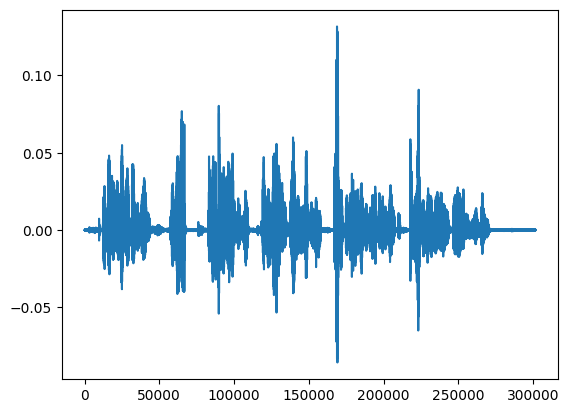

In [8]:
show_audio_plot(fleurs_hausa["train"][0]["audio"]["array"]) #rerun cell to get audio graph for new utterance

In [9]:
fleurs_hausa

DatasetDict({
    train: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 3259
    })
    validation: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 296
    })
    test: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 621
    })
})

# Try Huggingface Pipeline for reference numbers before creating custom model classes/pipeline

In [10]:
fleurs_hausa_train = load_dataset("google/fleurs", "ha_ng", split="train", cache_dir=cache_dir)
fleurs_hausa_val = load_dataset("google/fleurs", "ha_ng", split="validation", cache_dir=cache_dir)
fleurs_hausa_test = load_dataset("google/fleurs", "ha_ng", split="test", cache_dir=cache_dir)
# Hausa train/val/test = 3259/296/621

"""fleurs_igbo_train = load_dataset("google/fleurs", "ig_ng", split="train", cache_dir=cache_dir)
fleurs_igbo_val = load_dataset("google/fleurs", "ig_ng", split="validation", cache_dir=cache_dir)
fleurs_igbo_test = load_dataset("google/fleurs", "ig_ng", split="test", cache_dir=cache_dir)

fleurs_swahili_train = load_dataset("google/fleurs", "sw_ke", split="train", cache_dir=cache_dir)
fleurs_swahili_val = load_dataset("google/fleurs", "sw_ke", split="validation", cache_dir=cache_dir)
fleurs_swahili_test = load_dataset("google/fleurs", "sw_ke", split="test", cache_dir=cache_dir)
# Hausa train/val/test = 3259/296/621

fleurs_yoruba_train = load_dataset("google/fleurs", "yo_ng", split="train", cache_dir=cache_dir)
fleurs_yoruba_val = load_dataset("google/fleurs", "yo_ng", split="validation", cache_dir=cache_dir)
fleurs_yoruba_test = load_dataset("google/fleurs", "yo_ng", split="test", cache_dir=cache_dir)"""

Found cached dataset fleurs (/data/users/kashrest/asr-experiments/data/fleurs/google___fleurs/ha_ng/2.0.0/af82dbec419a815084fa63ebd5d5a9f24a6e9acdf9887b9e3b8c6bbd64e0b7ac)
Found cached dataset fleurs (/data/users/kashrest/asr-experiments/data/fleurs/google___fleurs/ha_ng/2.0.0/af82dbec419a815084fa63ebd5d5a9f24a6e9acdf9887b9e3b8c6bbd64e0b7ac)
Found cached dataset fleurs (/data/users/kashrest/asr-experiments/data/fleurs/google___fleurs/ha_ng/2.0.0/af82dbec419a815084fa63ebd5d5a9f24a6e9acdf9887b9e3b8c6bbd64e0b7ac)


'fleurs_igbo_train = load_dataset("google/fleurs", "ig_ng", split="train", cache_dir=cache_dir)\nfleurs_igbo_val = load_dataset("google/fleurs", "ig_ng", split="validation", cache_dir=cache_dir)\nfleurs_igbo_test = load_dataset("google/fleurs", "ig_ng", split="test", cache_dir=cache_dir)\n\nfleurs_swahili_train = load_dataset("google/fleurs", "sw_ke", split="train", cache_dir=cache_dir)\nfleurs_swahili_val = load_dataset("google/fleurs", "sw_ke", split="validation", cache_dir=cache_dir)\nfleurs_swahili_test = load_dataset("google/fleurs", "sw_ke", split="test", cache_dir=cache_dir)\n# Hausa train/val/test = 3259/296/621\n\nfleurs_yoruba_train = load_dataset("google/fleurs", "yo_ng", split="train", cache_dir=cache_dir)\nfleurs_yoruba_val = load_dataset("google/fleurs", "yo_ng", split="validation", cache_dir=cache_dir)\nfleurs_yoruba_test = load_dataset("google/fleurs", "yo_ng", split="test", cache_dir=cache_dir)'

In [11]:
n = random.randint(0, len(fleurs_hausa_train)-1)
print(f"n = {n}\n")
print(fleurs_hausa_train[n]["transcription"])
print()
print(fleurs_hausa_train[n]["raw_transcription"])

n = 1122

kimanin mintuna 3 da harba jirgin na'urara daukan hoton da ke ciki ta nuna yadda wani soson kariya ya balle daga jikin tankin mai

Kimanin mintuna 3 da harba jirgin, na’urara daukan hoton da ke ciki ta nuna yadda wani soson kariya ya balle daga jikin tankin mai.


## Character Vocabulary -- double check normalization from FLEURS


In [12]:
# Character vocabulary code from: https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Fine_Tune_XLSR_Wav2Vec2_on_Turkish_ASR_with_%F0%9F%A4%97_Transformers.ipynb#scrollTo=_0kRndSvqaKk
def extract_all_chars(batch):
  all_text = " ".join(batch["transcription"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

vocab_train = fleurs_hausa_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=fleurs_hausa_train.column_names)
vocab_val = fleurs_hausa_val.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=fleurs_hausa_val.column_names)
vocab_test = fleurs_hausa_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=fleurs_hausa_test.column_names)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

Map:   0%|          | 0/296 [00:00<?, ? examples/s]

Map:   0%|          | 0/621 [00:00<?, ? examples/s]

In [13]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]) | set(vocab_val["vocab"][0]))
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

# for word delimiter, change " " --> "|" (ex. "Hello my name is Kaleen" --> "Hello|my|name|is|Kaleen")
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict) # this is for CTC to predict the end of a character (e.g. "hhh[PAD]iiiiii[PAD]" == "hi")
print(len(vocab_dict))

82


In [14]:
# Save vocabulary file
hausa_vocab_file = out_dir+"vocab_hausa_fleurs_train_val_test.json"
with open(hausa_vocab_file, 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [15]:
tokenizer = Wav2Vec2CTCTokenizer(hausa_vocab_file, unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

In [16]:
sampling_rate = 16000
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=sampling_rate, padding_value=0.0, do_normalize=True, return_attention_mask=True)
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [17]:
rand_int = random.randint(0, len(fleurs_hausa_train)-1)
print(fleurs_hausa_train[rand_int]["raw_transcription"])
secs = len(fleurs_hausa_train[rand_int]["audio"]["array"])/sampling_rate
print(f"This utterance is {secs} seconds")
print(f"This utterance is sampled at {fleurs_hausa_train[rand_int]['audio']['sampling_rate']} Hz")
ipd.Audio(data=fleurs_hausa_train[rand_int]["audio"]["array"], autoplay=True, rate=16000)

Damisar Tiger tana cikin rukuni guda (Genus Panthera) kamar zakuna, damisar leopards, da jaguars. Wadannan dangin kyanwar guda huɗu sune kaɗai su ke iya ruri.
This utterance is 17.1 seconds
This utterance is sampled at 16000 Hz


In [18]:
def prepare_dataset(batch):
    audio = batch["audio"]
    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["transcription"]).input_ids
    return batch

In [19]:
fleurs_hausa_train = fleurs_hausa_train.map(prepare_dataset, remove_columns=fleurs_hausa_train.column_names, num_proc=4)
fleurs_hausa_val = fleurs_hausa_val.map(prepare_dataset, remove_columns=fleurs_hausa_val.column_names, num_proc=4)
fleurs_hausa_test = fleurs_hausa_test.map(prepare_dataset, remove_columns=fleurs_hausa_test.column_names, num_proc=4)

Map (num_proc=4):   0%|          | 0/3259 [00:00<?, ? examples/s]

/data/users/kashrest/miniconda3/envs/asr/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/data/users/kashrest/miniconda3/envs/asr/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/data/users/kashrest/miniconda3/envs/asr/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Tra

Map (num_proc=4):   0%|          | 0/296 [00:00<?, ? examples/s]

/data/users/kashrest/miniconda3/envs/asr/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/data/users/kashrest/miniconda3/envs/asr/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/data/users/kashrest/miniconda3/envs/asr/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Tra

Map (num_proc=4):   0%|          | 0/621 [00:00<?, ? examples/s]

/data/users/kashrest/miniconda3/envs/asr/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/data/users/kashrest/miniconda3/envs/asr/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/data/users/kashrest/miniconda3/envs/asr/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Tra

In [20]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [21]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [22]:
!who

kashrest pts/146      2023-05-02 10:52 (eduroam-bowers-128-114-155-147.ucsc.edu)
kashrest pts/255      2023-05-02 10:52 (:pts/146:S.0)
rwzhao   pts/319      2023-05-02 08:37 (gateway.soe.ucsc.edu)
kashrest pts/336      2023-05-02 11:06 (eduroam-bowers-128-114-155-147.ucsc.edu)
root     pts/359      2023-05-02 11:08 (ssh.soe.ucsc.edu)
kashrest pts/360      2023-05-02 11:08 (eduroam-bowers-128-114-155-147.ucsc.edu)
rwzhao   pts/361      2023-05-02 11:11 (gateway.soe.ucsc.edu)
kashrest pts/362      2023-05-02 12:20 (eduroam-bowers-128-114-155-147.ucsc.edu)


In [23]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

/tmp/ipykernel_12382/3399692002.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [24]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer, "cer": cer}

In [25]:
!nvidia-smi

Tue May  2 12:51:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:A1:00.0 Off |                    0 |
| N/A   61C    P0   262W / 300W |  77568MiB / 81920MiB |    100%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Training

In [ ]:
import time
# https://huggingface.co/docs/transformers/model_doc/wav2vec2#transformers.Wav2Vec2Config.attention_dropout
batch_size = 16
learning_rate = 3e-4
num_train_epochs = 30
attention_dropout = 0.1
hidden_dropout = 0.1
feat_proj_dropout = 0.0
mask_time_prob = 0.05
layerdrop = 0.1
warmup_steps = 500
    
hyperparameters_file = out_dir+"hyperparameters.jsonl"
with open(hyperparameters_file, "w") as f:
    obj = {"training batch size": batch_size,
           "learning rate": learning_rate,
           "number of training epochs": num_train_epochs,
           "attention dropout probability": attention_dropout,
           "hidden layer dropout probability": hidden_dropout,
           "feature projection layer dropout probability": feat_proj_dropout,
           "mask time probability": mask_time_prob,
           "layer dropout probability": layerdrop}
    json.dump(obj, f)

model = Wav2Vec2ForCTC.from_pretrained(
    pretrained_model_card, 
    attention_dropout=attention_dropout,
    hidden_dropout=hidden_dropout,
    feat_proj_dropout=feat_proj_dropout,
    mask_time_prob=mask_time_prob,
    layerdrop=layerdrop,
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)
""",
    ignore_mismatched_sizes=True"""
model.num_parameters() # facebook/wav2vec2-xls-r-300m
model.freeze_feature_extractor()
model.gradient_checkpointing_enable()



training_args = TrainingArguments(
  output_dir=out_dir,
  group_by_length=True,
  per_device_train_batch_size=batch_size,
  gradient_accumulation_steps=2,
  evaluation_strategy="steps",
  num_train_epochs=num_train_epochs,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=learning_rate,
  warmup_steps=warmup_steps,
  save_total_limit=2,
)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=fleurs_hausa_train,
    eval_dataset=fleurs_hausa_val, 
    tokenizer=processor.feature_extractor,
)
t1 = time.time()
trainer.train()
t2 = time.time()
print(f"Training took {t2-t1} seconds")

In [ ]:
12998/3600

In [ ]:
trainer.state.log_history

In [ ]:
!nvidia-smi
#torch.cuda.empty_cache()

# Evaluation

In [26]:
best_model_config = "facebook_wav2vec2-xls-r-300m/experiment_2/checkpoint-3000/"
best_model = Wav2Vec2ForCTC.from_pretrained(best_model_config).to("cuda")
#processor = Wav2Vec2Processor.from_pretrained(best_model_config)

In [27]:
input_dict = processor(fleurs_hausa_test[0]["input_values"], return_tensors="pt", padding=True)

logits = best_model(input_dict.input_values.to("cuda")).logits

pred_ids = torch.argmax(logits, dim=-1)[0]

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


OutOfMemoryError: CUDA out of memory. Tried to allocate 56.00 MiB (GPU 0; 79.20 GiB total capacity; 2.89 GiB already allocated; 23.31 MiB free; 2.92 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
fleurs_hausa_test[0].keys()

In [ ]:
preds = []
labels = []
device = "cuda:0" if torch.cuda.is_available() else torch.device('cpu')
# set up data loader
from torch.utils.data import DataLoader
test_loader = DataLoader(fleurs_hausa_test, collate_fn=data_collator)

for batch in test_loader:
    seq = batch["input_values"].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(seq, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        predicted_ids = torch.argmax(logits, dim=-1)

        # transcribe speech
        transcription = processor.batch_decode(predicted_ids)
        print(transcription)


In [ ]:
!nvidia-smi